In [1]:
#TODO test if working for MOP

In [1]:
import imp
from evaluation.metrics import redundancy, yNN, d1_distance , d2_distance
from cProfile import label
from datetime import datetime
import pandas as pd
import os
from evaluation.Plots import plot_basic_dataset
from evaluation.metrics import yNN_timeseries
import numpy as np
from pathlib import Path
import platform
import sklearn
import torch
from models.CNN_TSNet import UCRDataset, train
from models.ResNet import ResNetBaseline, fit, get_all_preds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
from TSEvo.CounterfactualExplanation import Explanation
from evaluation import WachterEtAl
import pickle
from evaluation.Plots import plot_CF, plot_CF_Original, plot_CF_Original_Closest
from tslearn.datasets import UCR_UEA_datasets
import warnings
from evaluation.Instance_BasedCF_NativeGuide import NativeGuidCF
from deap import creator, base, algorithms, tools
from deap.benchmarks.tools import hypervolume, diversity, convergence
from tslearn.datasets import UCR_UEA_datasets
from evaluation.Wachter_CF import Wachter
from evaluation.Nun_CF import NativeGuideCF

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0, -1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin,window=0)
run_on = ['Coffee','CBF','ElectricDevices','ECG5000','GunPoint','FordA'] 
draw_plot=False
os_type= platform.system()
os.environ["CUDA_VISIBLE_DEVICES"]=""
#mutation_type=['mutate_both']

for dataset in run_on: 
    if not os.path.isdir(f'./Results/Benchmarking/{dataset}'):
        os.mkdir(f'./Results/Benchmarking/{dataset}')
        
        if dataset in os.listdir('./Results/'):
            pass
        else:
            os.mkdir(f'./Results/{dataset}')
    X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
    train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
    test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2]) 
    enc1=pickle.load(open(f'./models/{dataset}/OneHotEncoder.pkl','rb'))
    test_y=enc1.transform(test_y.reshape(-1,1))
    n_classes = test_y.shape[1]
    if len(train_x.shape)==2:
        train_x=train_x.reshape(-1,train_x.shape[-2],train_x.shape[-1])
        test_x=test_x.reshape(-1,train_x.shape[-2],train_x.shape[-1])
    '''Load Model'''
    model = ResNetBaseline(in_channels=train_x.shape[-2], num_pred_classes=n_classes)
    model.load_state_dict(torch.load(f'./models/{dataset}/ResNet'))
    model.eval()
    
    y_pred= model(torch.from_numpy(test_x).float()).detach().numpy()
    test_y=y_pred
    '''Explanation Method'''
  
    '''Initialize Methods'''
    nguide_cf=NativeGuideCF(model,np.array(train_x).shape, (test_x,test_y))

    '''Calculate'''
    ynn=[]
    ynn_timeseries=[]
    red=[]
    sal_01=[]
    sal_02=[]
    not_valid=0
    wachter_cf=[]
    ynn_wachter=[]
    ynn_timeseries_wachter=[]
    red_wachter=[]
    sal_01_wachter=[]
    sal_02_wachter=[]
    not_valid_wachter=0
    ynn_cfg=[]
    ynn_timeseries_cfg=[]
    red_cfg=[]
    sal_01_cfg=[]
    sal_02_cfg=[]
    cfg_cf=[]
    not_valid_cfg=0
    ynn_ib=[]
    ynn_timeseries_ib=[]
    red_ib=[]
    sal_01_ib=[]
    sal_02_ib=[]
    ib_cf=[]
    not_valid_ib=0
    max_iteration=len(test_y)
    #TODO add time Measure
    for i, item in enumerate(test_x):
        print('Image Number ',{i})
        observation_01=item
        label_01=np.array([test_y[i]])#test_y[0]
        #TODO also in other sections !
        input_ = torch.from_numpy(np.array(item).reshape(1,1,-1)).float()
        output = torch.nn.functional.softmax(model(input_)).detach().numpy()
        y_target =np.argmax(output,axis=1)[0] #output.argmax()
        print('Y_Target', y_target)
  
        
        mlmodel = model 
    
        original = observation_01

    
     

        item = item.reshape(1,item.shape[-2],item.shape[-1])
        cfg_counterfactual,label_cfg=nguide_cf.explain(item,  y_target)#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
        cfg_cf.append(cfg_counterfactual)
        if not cfg_counterfactual is None:
            print(cfg_counterfactual.shape)
            ynn_cfg.append(yNN(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([label_cfg]))[0][0])
            ynn_timeseries_cfg.append(yNN_timeseries(cfg_counterfactual, mlmodel,train_x,5,labels=np.array([label_cfg]))[0][0])
            red_cfg.append(redundancy(original, cfg_counterfactual, mlmodel,labels=np.array([label_cfg]))[0])
            sal_01_cfg.append(d1_distance(observation_01,np.array(cfg_counterfactual)))
            sal_02_cfg.append(d2_distance(observation_01,np.array(cfg_counterfactual)))
            if label_cfg == np.argmax(label_01,axis=1):
                not_valid_cfg=not_valid_cfg+1

        else: 
            print('GradCam not a valid CF!')
            not_valid_cfg=not_valid_cfg+1

        #Other 2 
        item = item.reshape(1,item.shape[-2],item.shape[-1])
        reference_set=(train_x,train_y)
        ib_counterfactual,label_ib=nguide_cf.explain(item,  y_target,method='dtw_bary_center')#(mlmodel, item, y_target).reshape(np.array(pop).shape[0],np.array(pop).shape[1],np.array(pop).shape[2])
        ib_cf.append(ib_counterfactual)
    
        if not ib_counterfactual is None:
            ib_counterfactual=ib_counterfactual.reshape(1,1,-1)
            ynn_ib.append(yNN(ib_counterfactual,mlmodel,train_x,5,labels=np.array([label_ib]))[0][0])
            ynn_timeseries_ib.append(yNN_timeseries(ib_counterfactual, mlmodel,train_x,5,labels=np.array([label_ib]))[0][0])
            red_ib.append(redundancy(original, ib_counterfactual, mlmodel,labels=np.array([label_ib]))[0])
            sal_01_ib.append(d1_distance(observation_01,np.array(ib_counterfactual)))
            sal_02_ib.append(d2_distance(observation_01,np.array(ib_counterfactual)))
            if label_ib == np.argmax(label_01,axis=1):
                not_valid_ib=not_valid_ib+1
        else: 
            print('Instance-Base not a valid CF!')
            not_valid_ib=not_valid_ib+1
        
        if i ==19:
            break

    pickle.dump(ib_cf,open(f'./Results/Benchmarking/{dataset}/ib_cf_new.pkl','wb'))
    pickle.dump(cfg_cf,open(f'./Results/Benchmarking/{dataset}/cfg_cf_new.pkl','wb'))

    #TODO Problems with CF Output
    results = pd.DataFrame([])
    results['method']=['TS_Evo', 'Wachter', 'NG_DBN', 'NG_GradCam']
    results['validity']=[1-not_valid/20, 1-not_valid_wachter/20,1-not_valid_ib/20,1-not_valid_cfg/20]
    #results['closest']=sal_02
    results.to_csv(f'./Results/Benchmarking/{dataset}/Validity.csv')

Image Number  {0}
Y_Target 0
(1, 286)
Target 1
query [[0.04622965 0.9537704 ]]
0.7000191
Image Number  {1}
Y_Target 0
(1, 286)
Target 1
query [[2.834309e-05 9.999716e-01]]
0.0009890905
Image Number  {2}
Y_Target 0
(1, 286)
Target 1
query [[0.04622965 0.9537704 ]]
9.3739734e-05
Image Number  {3}
Y_Target 0
(1, 286)
Target 1
query [[4.9226925e-05 9.9995077e-01]]
0.0024518068
Image Number  {4}
Y_Target 0
(1, 286)
Target 1
query [[7.7316596e-05 9.9992263e-01]]
0.0053800596
Image Number  {5}
Y_Target 0
(1, 286)
Target 1
query [[7.7316596e-05 9.9992263e-01]]
0.0002895733
Image Number  {6}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[0.04622965 0.9537704 ]]
0.04622965
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {7}
Y_Target 0
(1, 286)
Target 1
query [[7.7316596e-05 9.9992263e-01]]
0.0013617637
Image Number  {8}
Y_Target 0
(1, 286)
Target 1
query [[4.9226925e-05 9.9995077e-01]]
8.338663e-05
Image Number  {9}

Image Number  {0}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[5.2842117e-13 1.0000000e+00 3.1672053e-18]]
5.2842117e-13
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {1}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[1.6598295e-06 9.9999833e-01 4.9774688e-15]]
1.6598295e-06
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {2}
Y_Target 0
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 1
query [[6.2139206e-06 6.8475462e-23 9.9999380e-01]]
6.1399037e-12
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {3}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[1.5235433e-06 9.9999845e-01 2.4271765e-15]]
1.5235433e-06
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {4}
Y_Target 1
Generator Swap: No 

Image Number  {0}
Y_Target 5
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 3
query [[6.6341271e-28 1.8679925e-17 3.6076667e-22 1.0868920e-06 4.5460680e-10
  9.9999893e-01 3.2664271e-09]]
1.086892e-06
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {1}
Y_Target 4
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 3
query [[3.6349914e-14 9.5317754e-09 1.2266660e-09 1.7870544e-01 6.5278763e-01
  2.4489745e-02 1.4401719e-01]]
0.17870544
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {2}
Y_Target 5
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 3
query [[5.9108392e-21 4.1863089e-24 6.1206272e-23 3.6310028e-06 1.0223625e-11
  9.9999642e-01 2.1272342e-10]]
3.6310028e-06
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {3}
Y_Target 5
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 6
query [[6.6452

Image Number  {0}
Y_Target 0
(1, 140)
Target 1
query [[4.1785654e-01 5.8206099e-01 1.3931762e-08 8.2048369e-05 3.9626650e-07]]
1.1427172e-05
Image Number  {1}
Y_Target 0
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 2
query [[2.3153771e-03 1.6225578e-02 1.0969474e-07 9.8145890e-01 1.2583838e-10]]
2.6823452e-07
Image Number  {2}
Y_Target 0
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 2
query [[2.4777619e-05 9.6368200e-01 1.6112863e-11 3.6293201e-02 2.3813282e-10]]
4.9717596e-06
Image Number  {3}
Y_Target 0
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 2
query [[8.5511738e-03 9.2991081e-04 3.8052651e-05 9.9048084e-01 7.6315365e-13]]
1.4906935e-05
Image Number  {4}
Y_Target 0
(1, 140)
Target 3
query [[8.5511738e-03 9.2991081e-04 3.8052651e-05 9.9048084e-01 7.6315365e-13]]
0.04935598
Image Number  {5}
Y_Target 0
(1, 140)
Target 3
query [[2.7546739e-06 2.9548043e-01 1.9013595e-07 7.0451665e-01 1.9895869e-14]]
0.1308

Image Number  {0}
Y_Target 0
(1, 150)
Target 1
query [[0.21390921 0.78609085]]
0.051230986
Image Number  {1}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[0.04130688 0.95869315]]
0.041306883
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {2}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[1.7920812e-08 1.0000000e+00]]
1.7920812e-08
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {3}
Y_Target 0
(1, 150)
Target 1
query [[0.0708139  0.92918605]]
0.06266879
Image Number  {4}
Y_Target 0
(1, 150)
Target 1
query [[0.05837168 0.94162834]]
0.004686222
Image Number  {5}
Y_Target 0
(1, 150)
Target 1
query [[0.0278986 0.9721014]]
0.018557725
Image Number  {6}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[0.12978722 0.87021285]]
0.12978722
Instance-Based: No Counterfactual found
Instance-Base 

Image Number  {0}
Y_Target 0
(1, 500)
Target 1
query [[2.4e-44 1.0e+00]]
1.1769907e-05
Image Number  {1}
Y_Target 0
(1, 500)
Target 1
query [[2.3179938e-07 9.9999976e-01]]
1.1e-44
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {2}
Y_Target 0
(1, 500)
Target 1
query [[7.691376e-12 1.000000e+00]]
7.060069e-33
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {3}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[2.1203006e-27 1.0000000e+00]]
2.1203006e-27
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {4}
Y_Target 0
(1, 500)
Target 1
query [[7.1869758e-31 1.0000000e+00]]
5.113723e-22
Image Number  {5}
Y_Target 1
Generator Swap: No Counterfactual found
GradCam not a valid CF!
Target 0
query [[1.7814397e-25 1.0000000e+00]]
1.7814397e-25
Instance-Based: No Counterfactual found
Instance-Base not a valid CF!
Image Number  {6}
Y_Target 0
(1, 500)


In [2]:
ynn_timeseries_cfg

[0.8,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 0.8,
 1.0,
 0.8,
 0.8,
 1.0,
 1.0,
 1.0,
 0.8,
 1.0,
 0.8,
 1.0]

In [4]:
sal_02_cfg

[0.5701173317543633,
 1.5404796552633933,
 1.052611597557521,
 377186485101.4962,
 0.7731305507770719,
 0.33807422440614376,
 0.2466882231221098,
 290705907856.20825,
 0.5003578722619498,
 0.27087293486599356,
 117565994299.06354,
 1.6652318068169385,
 3.0983444256787585,
 0.5211766576997672,
 97979469498.90263,
 2.1074569269423082,
 1.116839285474885]

In [9]:
np.sum(np.abs(test_x[3] -  cfg_cf[3]))

52806107914209.47

In [15]:
np.max(cfg_cf[3])

1.8147850881624383

In [16]:
np.min(cfg_cf[3])

-52806107914168.78

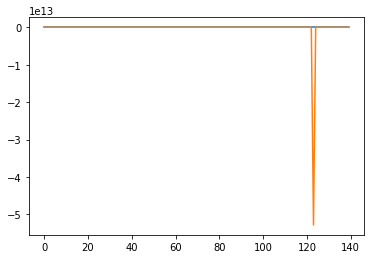

In [13]:
plt.plot(test_x[3].reshape(-1,1))
plt.plot(np.array(cfg_cf[3].reshape(-1,1)))